# Import modules

In [2]:
!pip3 install pdflatex qiskit ipywidgets quantum-decomp pylatexenc import-ipynb
!wget https://raw.githubusercontent.com/hkhetawat/QArithmetic/master/QArithmetic.py
!wget https://raw.githubusercontent.com/hkhetawat/QArithmetic/master/qft.py

Defaulting to user installation because normal site-packages is not writeable


--2022-09-23 10:22:40--  https://raw.githubusercontent.com/hkhetawat/QArithmetic/master/QArithmetic.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13886 (14K) [text/plain]
Saving to: ‘QArithmetic.py.2’

QArithmetic.py.2    100%[===================>]  13,56K  --.-KB/s    in 0s      

2022-09-23 10:22:41 (36,4 MB/s) - ‘QArithmetic.py.2’ saved [13886/13886]

--2022-09-23 10:22:41--  https://raw.githubusercontent.com/hkhetawat/QArithmetic/master/qft.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1820 (1,8K) [text/plain]
Saving

In [4]:
import import_ipynb, qiskit, functools, QArithmetic
import numpy as np
import math
import matplotlib as plt
from itertools import chain
from qiskit import Aer, IBMQ, QuantumRegister, ClassicalRegister, QuantumCircuit, execute, assemble, transpile
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer import noise
from qiskit.circuit import Gate
from qiskit.visualization import plot_histogram

In [5]:
class groverPhase():
    
    '''Compactar en cajas la combinación lineal???'''
    
    def __init__(self, initH = False):
        self.initH = initH # Ensamblado con el H inicial?
    
    def assembleSubCirc(func):
        
        
        def inner(self, qCircuit, *args):
            registerClass = type(QuantumRegister(1, 'dummy'))
            dummyCircuitSize = 0
            wireList = []
            wires = []
            
            for var in args:
                if type(var) == registerClass:
                    wires.append(var)
                    
            for wire in wires:
                dummyCircuitSize += len(wire)
                wireList += list(wire)
            
            
            dummyCircuit = QuantumCircuit(*wires, name = f'{func.__name__}')

            qCircuit.append(func(self, dummyCircuit, *args), wireList)
            
            
            
        return inner
    
    
    @assembleSubCirc
    def addition(self, qCircuit, wiresA, wiresB):
        '''operador de suma'''
        numWires = len(wiresA)
        
        QArithmetic.add(qCircuit, wiresA, wiresB, numWires)
        
        return qCircuit
        
            
    @assembleSubCirc        
    def product(self, qCircuit, threadOfGen, threadOfLambda, threadOfLinear):
        
        num = len(threadOfGen)
        QArithmetic.mult(qCircuit, threadOfGen, threadOfLambda, threadOfLinear[:2*num], num)
        
        return qCircuit
    
    def linearCombination(self, qCircuit, wiresOfGen, numberOfGen, wiresOfLambda, wiresOfLinear):
        '''operador de combinación lineal'''
        
        for i in range(len(wiresOfGen)):
            self.product(qCircuit, wiresOfGen[i], wiresOfLambda[i], wiresOfLinear[i])
        
        for i in range(numberOfGen-1):
           
            self.addition(qCircuit, wiresOfLinear[i], wiresOfLinear[i+1])
            
        return qCircuit
    
    @assembleSubCirc
    def substractSought(self, qCircuit, wiresOfSought, wiresOfLinearCom):
        QArithmetic.sub(qCircuit, wiresOfSought, wiresOfLinearCom, len(wiresOfSought)-1)
        
        return qCircuit
    
    
    @assembleSubCirc
    def isCero(self, qCircuit, control, target): # Cero -> Zero
        
        qCircuit.x(control)
        qCircuit.mct(control, target)
        
        return qCircuit
        
    

    @assembleSubCirc
    def difussor(self, qCircuit, *lambdaWires):
        '''Crea un difusor en los hilos implicados'''
        nlw = len(lambdaWires)
        qCircuit.h(range(nlw))
        qCircuit.x(range(nlw))
    
        qCircuit.h(0)
        qCircuit.mct(list(range(1, nlw)), 0)
        qCircuit.h(0)

        qCircuit.x(range(nlw))
        qCircuit.h(range(nlw))
            
        return qCircuit
    
    def induceSuperposition(self, qCircuit, wires):
        
        if not self.initH:
            
            for i in range(len(wires)):
                qCircuit.h(wires[i])
            self.initH = True
            
    
    def semigroupMembershipOracle(self, qCircuit, wiresOfGenerators, numberOfGenerators, wiresOfLambda,
                                  wiresOfLinCom, wiresOfSought, threadPhaseKickback):
        
        
        self.linearCombination(qCircuit, wiresOfGenerators, numberOfGenerators, wiresOfLambda,
                                   wiresOfLinCom)
        
        self.substractSought(qCircuit, wiresOfSought, wiresOfLinCom[-1])
        
        self.isCero(qCircuit, wiresOfLinCom[-1], threadPhaseKickback)
        
        
        

In [12]:
class semigroupMembership(groverPhase):
    
    '''El numero opt. de iter (sol simple) es sqrt(2^n)'''
    
    def __init__(self, soughtElement, sizeOfLambda = None, *generators):
        super().__init__()
        self.soughtElement = soughtElement
        self.generators = generators
        self.numberOfGenerators = len(generators)
        if sizeOfLambda==None:
            self.sizeOfLambda = max([math.ceil(math.log2(gen)) for gen in generators])
        else:
            self.sizeOfLambda = sizeOfLambda
        self.nIter = 1 # We cannot calculate ir properly
            
        '''Numero de iteraciones del algoritmod e grover'''
        self.numbIter = math.floor(math.sqrt(self.numberOfGenerators*self.sizeOfLambda))
        
        
    def dec2binQR(self, qReg, number): # ****
        '''Toma un valor decimal y un registro, introduce el equiv. binairo en el registro.'''
        
        binExp = bin(number) #−> 0bxxxxx...
            
        if len(qReg)<len(binExp)-2:
            print(f"error al convertir en binario{len(qReg)} and {len(binExp)-2}")
            return
        i=0
        # De derecha a izquierda
        while binExp[-(i+1)]!='b':
            if binExp[-(i+1)]=='1':
              self.circ.x(qReg[i])
            i += 1
        del(i, binExp)
    
    def setUpWires(self):
        
        sizeOfGenerators = self.sizeOfLambda # Tienen que coincidir para poder multiplicarlos.
        
        self.wireQCounting = QuantumRegister(1, 't')
        
        self.wiresOfGenerators = [QuantumRegister(sizeOfGenerators, f's{i}')
                                    for i in range(self.numberOfGenerators)]
        
        self.wiresOfLambda = [QuantumRegister(self.sizeOfLambda, f'lambda{i}')
                                    for i in range(self.numberOfGenerators)]
        
        self.wiresOfLinCom = []
        
        for i in range(self.nIter):
            
            for j in range(self.numberOfGenerators-1):
                
                self.wiresOfLinCom.append(QuantumRegister(self.sizeOfLambda*2 + j, f'linearCom{j}_it{i}'))
            
            self.wiresOfLinCom.append(QuantumRegister(self.sizeOfLambda*2 + self.numberOfGenerators,
                                                    f'linearCom{self.numberOfGenerators-1}_it{i}'))
        
        
        # Same size to substract
        self.wiresOfSought = QuantumRegister(self.sizeOfLambda*2 + self.numberOfGenerators, 'a')
        
        self.threadPhaseKickback = QuantumRegister(1, 'b')      
            


        self.circ = QuantumCircuit(self.wireQCounting, *self.wiresOfGenerators, *self.wiresOfLambda,
                                   *self.wiresOfLinCom, self.wiresOfSought, self.threadPhaseKickback,
                                   name='Semigroup Membership Algorithm')


    def setUpPhaseKickback(self):
        
        self.circ.x(self.threadPhaseKickback)
        self.circ.h(self.threadPhaseKickback)        
        
    def setUpValues(self):
        
        for i in range(self.numberOfGenerators):
            self.dec2binQR(self.wiresOfGenerators[i], self.generators[i])
        self.dec2binQR(self.wiresOfSought, self.soughtElement)
        
    def controlledSuperposition(self, targ, ctrl):
        
        for wire in targ:
            
            self.circ.ch(ctrl, wire)
    
    def semigroupMembershipAlgorithm(self):
        
        self.setUpWires()
        self.setUpValues()
        self.setUpPhaseKickback()
        self.circ.h(self.wireQCounting)
        self.circ.barrier()
        
        #self.induceSuperposition(self.circ, self.wiresOfLambda)
        self.controlledSuperposition(self.wiresOfLambda, self.wireQCounting)
        
        self.circ.barrier()
        
        for i in range(self.nIter):
            
            self.semigroupMembershipOracle(self.circ, self.wiresOfGenerators, self.numberOfGenerators,
                                           self.wiresOfLambda,
                                           self.wiresOfLinCom[self.numberOfGenerators*i:self.numberOfGenerators*(1+i)],
                                           self.wiresOfSought, self.threadPhaseKickback)
            
            self.circ.barrier() # Si no pones las barreras las cajas se mezclan igualmente.

            self.difussor(self.circ, *self.wiresOfLambda)
            
            self.circ.barrier() # Si no pones las barreras las cajas se mezclan igualmente.
            
            
        self.circ.h(self.wireQCounting)  # QFT == H para qubits = 1

In [13]:
test1 = semigroupMembership(3, None, 2, 3)
test1.semigroupMembershipAlgorithm()

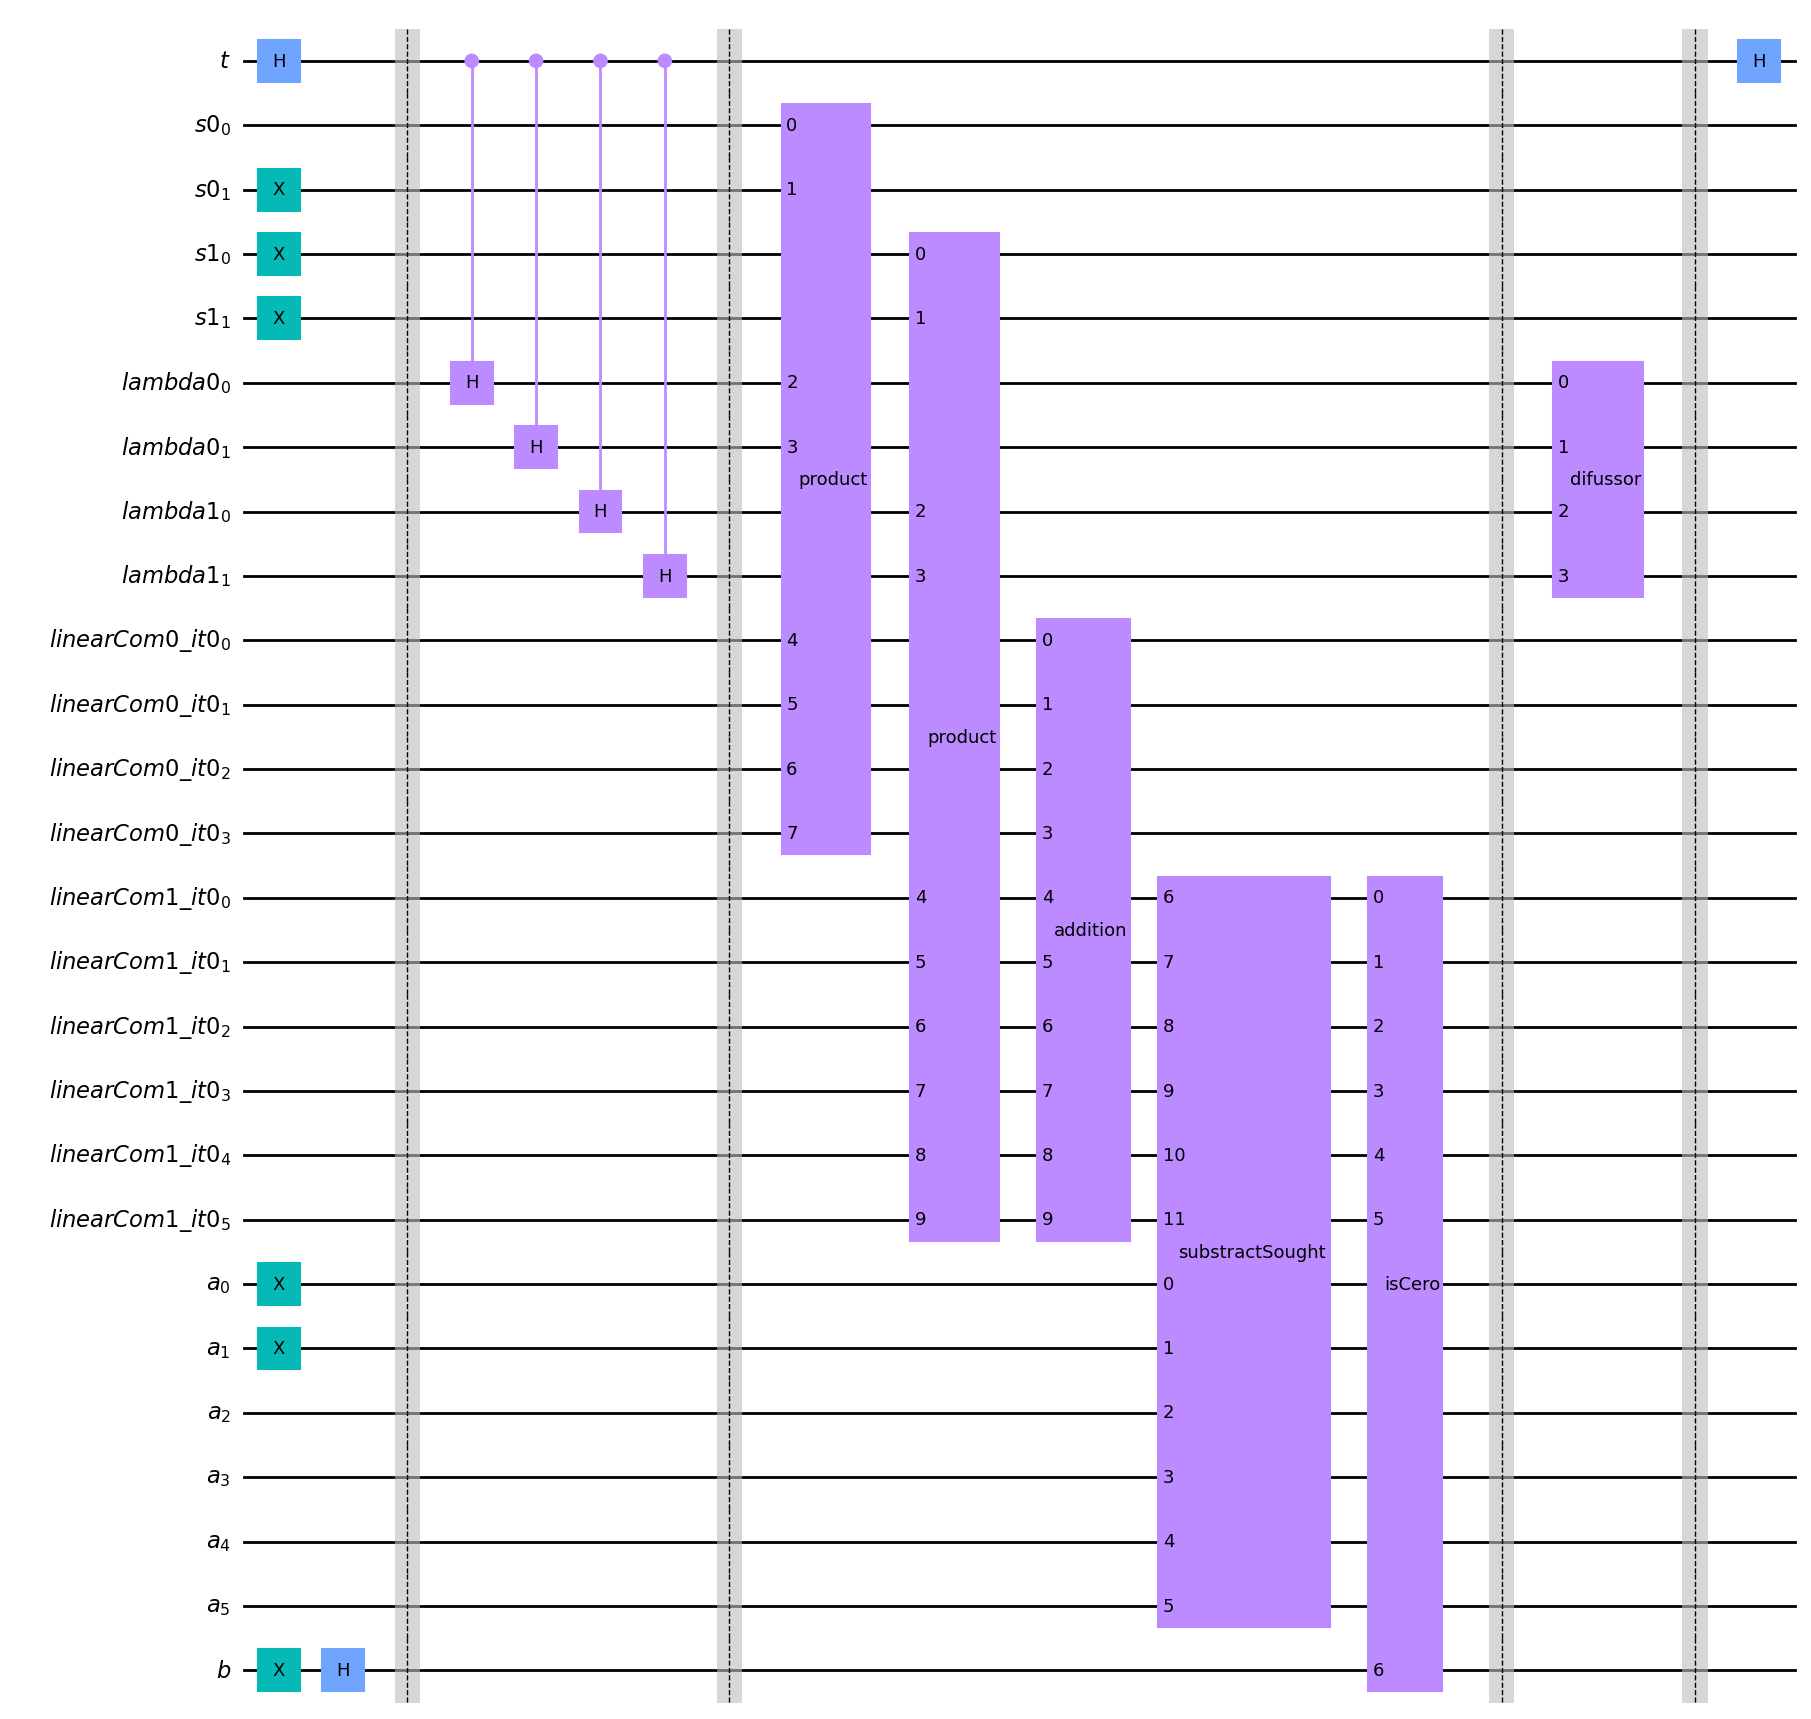

In [14]:
test1.circ.draw('mpl')